# Text to Speech

When solving some problem with deep learning in practice, you search the Web for the latest paper that solves that task, and take its implementation from GitHub. However, often there is no code, so being able to **reimplement a paper** is a vital skill. You will likely have to do it in your course project, and we are going to practice it in this assignment.

Let's focus on the task of text to speech (**TTS**) synthesis.

![](https://user-images.githubusercontent.com/9570420/81783573-392ed600-9504-11ea-98da-86ac05457c29.png)

## Data

 Intuitively, in the real world your dataset would be a set of pairs:

* text (string);
* **target**: raw audio of a person saying `text` (array of amplitude values sampled e.g. 44100 times per second — see an example plotted above).

We give you a simplified problem statement, with one dataset sample being an utterance described by

* list of [ARPAbet phonemes](http://www.speech.cs.cmu.edu/cgi-bin/cmudict#phones);
* *phoneme alignment*, i.e. start time (frame) and duration for each phoneme;
* **target**: [mel spectrogram](https://pytorch.org/audio/transforms.html#torchaudio.transforms.MelSpectrogram) of a person saying text.

![image](https://user-images.githubusercontent.com/9570420/81795777-2a9cea80-9515-11ea-99eb-05915f803af1.png)

In [0]:
import scipy.io.wavfile

import torch

from matplotlib import pyplot as plt
%matplotlib inline

from pathlib import Path

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 4")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
![ ! -d "LJ-Speech-aligned" ] && unzip -q "{ '/content/drive/My Drive/CopyLJ-Speech-aligned.zip'}"
!git clone --recursive https://github.com/shrubb/waveglow.git -b denoiser-fix
!wget -c https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt

fatal: destination path 'waveglow' already exists and is not an empty directory.
--2020-05-24 15:50:03--  https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.89.201.137, 35.161.182.61
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.89.201.137|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://s3.us-west-2.amazonaws.com/prod-model-registry-ngc-bucket/org/nvidia/models/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt?response-content-disposition=attachment%3B%20filename%3D%22waveglow_256channels_ljs_v2.pt%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjECAaCXVzLXdlc3QtMiJGMEQCIHhMjHImnKSF2LKAzLpOuFxOx1cl079Rj9R8KdtPBFkIAiBfrdeKwbgQXimMvV8cCnAiz4Ps3ZR%2Bq78EE8fAfDZz9iq0Awh5EAIaDDc4OTM2MzEzNTAyNyIM2kDbzNhvxXKf%2FSVJKpEDalT53BTVAgTHe%2FkfQiL1rkE%2FpBSlu8gxf71ffWZrwyI4c

In [4]:
 !pip install git+https://github.com/shrubb/listener.git


  Cloning https://github.com/shrubb/listener.git to /tmp/pip-req-build-npta2voj
  Running command git clone -q https://github.com/shrubb/listener.git /tmp/pip-req-build-npta2voj
  Created wheel for listener: filename=listener-1.0.0a1-cp36-none-any.whl size=87098 sha256=8db1eb6a72af21bb7fa56f21fe29a4da6676e561e045a0e2d3f542bf42b17af0
  Stored in directory: /tmp/pip-ephem-wheel-cache-qp885xlx/wheels/41/ec/98/7c89227ba5da35ff1e7d5284bb58e0b98e93389fc1f77c407b
Successfully built listener


Use this Python module to handle our dataset. It's documented, so when in doubt, use `help()` or read the code with `??lj_speech`.

In [0]:
import lj_speech


In [0]:
# DATASET_ROOT = Path('.')
DATASET_ROOT = Path('LJ-Speech-aligned/')
train_dataset, val_dataset = lj_speech.get_dataset(DATASET_ROOT)

In [0]:
orig_phonem_indexes = list(sorted(lj_speech.POSSIBLE_PHONEME_CODES))
phonems_dict = {}
for i in range(len(orig_phonem_indexes)):
  phonems_dict[orig_phonem_indexes[i]] = i+1
# phonems_dict

In [0]:
def collate_tts(batch, r):
    batch_size = len(batch)
    max_phonemes_length = 137
    max_spectrogram_length = 870
        
 
    spectrograms = torch.zeros((batch_size,80,max_spectrogram_length))

    phonemes = torch.ones((batch_size, max_phonemes_length))*54
    phonemes_start = torch.zeros((batch_size, max_phonemes_length))
    phonemes_duration = torch.zeros((batch_size, max_phonemes_length))

    for batch_index, sample in enumerate(batch):
        for i, phoneme in enumerate(sample['phonemes_code']):
            phonemes[batch_index][i] = phonems_dict[phoneme]
        
        
        spectrogram_buf = torch.from_numpy(sample['spectrogram']).type(torch.float32)
        spectrograms[batch_index, :, :spectrogram_buf.shape[1]] = spectrogram_buf
        
        phonemes_start[batch_index, :i+1] = torch.FloatTensor(sample['phonemes_start'])
        
        phonemes_duration[batch_index, :i+1] = torch.FloatTensor(sample['phonemes_duration'])

    mask = torch.zeros_like((spectrograms), dtype= torch.float32)
    mask[spectrograms!=0.0] = 1.0
    mask = mask.type(torch.float32)

    return mask, phonemes_start, phonemes_duration, phonemes, spectrograms

In [0]:
from torchvision import models, transforms, utils
from torch.utils.data import DataLoader

DS_ljspeech_loader =DataLoader(train_dataset, collate_fn=lambda batch: collate_tts(batch , 8), batch_size=31, shuffle=True, num_workers=0)
vDS_ljspeech_loader =DataLoader(val_dataset, collate_fn=lambda batch: collate_tts(batch , 8), batch_size=31, shuffle=False, num_workers=0)

In [0]:
import torch
from torch import nn
class BatchNormConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, 5, padding=2)
        self.conv2 = nn.Conv1d(in_channels, out_channels, 1)
        self.bnorm = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.init_weights()


    def init_weights(self):
      for m in self.modules():
        if hasattr(m, 'weight') and m.weight.dim()>1:
          torch.nn.init.xavier_uniform_(m.weight.data)

    def forward(self, x):
        # a= x
        a = self.conv2(x)
        x = self.conv1(x)
        x = self.relu(x) #if self.relu is True else x
        x = self.bnorm(x) 
        x = self.dropout(x)
        return  x+a


class Encoder(nn.Module):
    def __init__(self,
                 
                  hid_dim,
                 ):
        super().__init__()
        # self.input_dim = input_dim
        self.hid_dim = hid_dim
        # self.padding_index = padding_index  # if None, don't use masking
        
        # embeddings
        self.embedding = nn.Embedding( 55, self.hid_dim)
        self.convd1block1 = BatchNormConv(self.hid_dim, self.hid_dim, 5, 0.5)
        self.convd1block2 = BatchNormConv(self.hid_dim, self.hid_dim, 5, 0.5)
        self.convd1block3 = BatchNormConv(self.hid_dim, 2*self.hid_dim, 5, 0.5)
        self.convd1block4 = BatchNormConv(2*self.hid_dim, 2*self.hid_dim, 5, 0.5)
        self.convd1block5 = BatchNormConv(2*self.hid_dim, 2*self.hid_dim, 5, 0.5)
        self.gru = nn.GRU(self.hid_dim*2, self.hid_dim ,batch_first=True, bidirectional=True)
    
    def forward(self, x):
      
        x = self.embedding(x)
        x= torch.transpose(x,1,2)
        # print(x.shape)
        x =self.convd1block1(x)
        # print(x.shape)
        x =self.convd1block2(x)
        # print(x.shape)
        x =self.convd1block3(x)
        # print(x.shape)
        x =self.convd1block4(x)
        # print(x.shape)
        x =self.convd1block5(x)
        # print(x.shape)
        x= torch.transpose(x,1,2)
        x, y =self.gru(x)

        return x

In [0]:
import numpy as np
class alignment_part(nn.Module):

    def __init__(self, max_spectrogram_length=870):

        super().__init__()
        self.max_spectrogram_length = max_spectrogram_length
    
    
    def forward(self, phonemes_hidden_representation, durations):
        output_batch = torch.tensor([], dtype= torch.float32).to(device)
        f = torch.tensor([], dtype= torch.float32).to(device)

        for i, (batch_phonemes_hidden, batch_durations) in enumerate(zip(phonemes_hidden_representation, durations)):
            batch_buf = torch.repeat_interleave(batch_phonemes_hidden, batch_durations.int().long(), dim=0)
            a= batch_buf.shape
            fp = torch.cat([torch.linspace(0,1 ,int(num.item()))  for num in batch_durations])
            batch_length_buf = np.min([batch_buf.shape[0], self.max_spectrogram_length])

            if batch_length_buf == self.max_spectrogram_length:
                batch_buf = batch_buf[:self.max_spectrogram_length,:]
                fp = fp[:self.max_spectrogram_length]
            batch_buf = batch_buf.view(1, batch_buf.shape[0], batch_buf.shape[1])
            fp = fp.view(1, a[0])
            batch_buf = F.pad(input=batch_buf, 
                              pad=(0, 0, 0, self.max_spectrogram_length - a[0], 0, 0), 
                              mode='constant', value=0)
            fp = F.pad(input=fp, 
                              pad=(0,  self.max_spectrogram_length - a[0]), 
                              mode='constant', value=0)
            fp=fp.to(device)
            f = torch.cat((f,fp),0)
            output_batch = torch.cat((output_batch, batch_buf), 0)
        
        return torch.cat((f.unsqueeze(2) ,output_batch), 2)

In [0]:
class Decoder(nn.Module):
  def __init__(self ,hid_dim):
      super().__init__()
      self.out_dim = 80
      self.hid_dim = hid_dim
      self.gru1 = nn.GRU(self.hid_dim*2+1, self.hid_dim ,batch_first=True)
      self.gru2 = nn.GRU(self.hid_dim, self.hid_dim ,batch_first=True)
      self.conv1 = nn.Conv1d(self.hid_dim, self.out_dim, 1)

      self.convd1block1 = BatchNormConv(self.hid_dim, self.hid_dim, 5, 0.0)
      self.convd1block2 = BatchNormConv(self.hid_dim, self.hid_dim, 5, 0.0)
      self.convd1block3 = BatchNormConv(self.hid_dim, self.hid_dim, 5, 0.0)
      self.convd1block4 = BatchNormConv(self.hid_dim, self.hid_dim, 5, 0.0)
      self.convd1block5 = BatchNormConv(self.hid_dim, self.hid_dim, 5, 0.0)
      self.conv2 = nn.Conv1d(self.hid_dim, self.out_dim, 1)


      self.init_weights()


  def init_weights(self):
      for m in self.modules():
        if hasattr(m, 'weight') and m.weight.dim()>1:
          torch.nn.init.xavier_uniform_(m.weight.data)
  
  def forward(self,x):
    self.gru1.flatten_parameters()
    self.gru2.flatten_parameters()
    
    x, y = self.gru1(x)
    # print(type(x))
    x, y = self.gru2(x)
    a= torch.transpose(x,1,2)
    a = self.conv1(a)
   
    x= torch.transpose(x,1,2)
    x =self.convd1block1(x)
    x =self.convd1block2(x)
    x =self.convd1block3(x)
    x =self.convd1block4(x)
    x =self.convd1block5(x)
    
    x = self.conv1(x)

    return a, x

In [0]:
import torch
from torch import nn

class DurationModel(nn.Module):
  def __init__(self, hid_dim):
    super().__init__() 
    self.hid_dim = hid_dim
    # self.out = out
    self.embedding = nn.Embedding(55, self.hid_dim)
    self.lstm1 = nn.LSTM(self.hid_dim, int(self.hid_dim) ,batch_first=True, bidirectional=True)
    self.lstm2 = nn.LSTM(self.hid_dim*2, self.hid_dim ,batch_first=True, bidirectional=True)
    self.lstm3 = nn.LSTM(self.hid_dim*2, self.hid_dim ,batch_first=True, bidirectional=True)
    self.fc = nn.Linear(self.hid_dim*2 , 1)
    self.relu = nn.ReLU()
    self.init_weights()


  def init_weights(self):
      for m in self.modules():
        if hasattr(m, 'weight') and m.weight.dim()>1:
          torch.nn.init.xavier_uniform_(m.weight.data)


  def forward(self, x):
    shape = x.shape
    # print(shape)
    # print(x.dtype)
    x = x.long()
    x = self.embedding(x)
    x,y = self.lstm1(x)
    x,y = self.lstm2(x)
    x,y = self.lstm3(x)
    # shape_out = x.shape
    # print(x.shape)
    x = self.fc(x).view(-1, shape[1])
    x = self.relu(x)

    return x

In [0]:
class durian(nn.Module):
    def __init__(self,
                 hid_dim = 256):
        super().__init__()
        self.hid_dim = hid_dim
        self.encoder = Encoder(self.hid_dim)
        self.alignment_part = alignment_part()
        self.decoder = Decoder(self.hid_dim)
    def forward(self, codes, durations):
      x= self.encoder(codes)
      x_aligned = self.alignment_part(x, durations)
      pre_pn, post_pn = self.decoder(x_aligned)
      return pre_pn, post_pn

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = durian().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [0]:
criterion = nn.L1Loss()

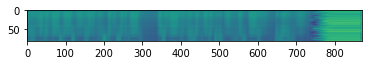

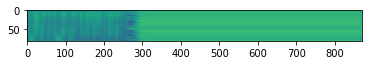

0 train.  2.162027114331011
0 val  1.6073715686798096


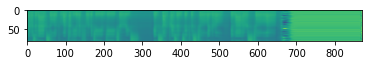

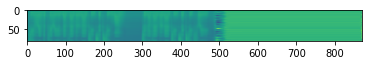

1 train.  1.3296458701245255
1 val  1.1641449928283691


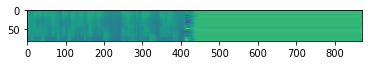

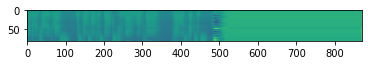

2 train.  1.1352252675696033
2 val  1.0737223625183105


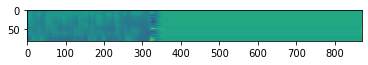

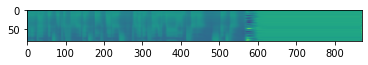

3 train.  1.0837555453714722
3 val  1.0369149148464203


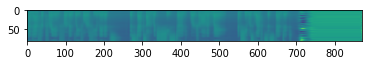

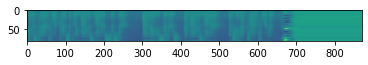

4 train.  1.0575545041828565
4 val  1.018756926059723


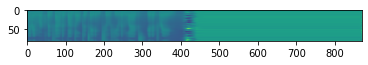

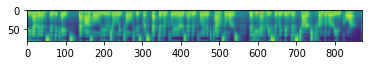

5 train.  1.0405477535753092
5 val  1.013089895248413


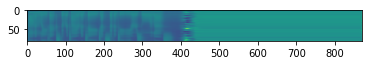

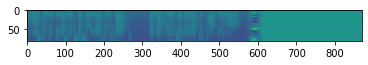

6 train.  1.029425377492973
6 val  1.001344010233879


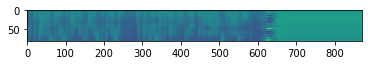

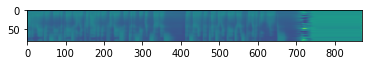

7 train.  1.0193315107099765
7 val  0.9902248829603195


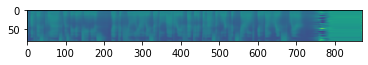

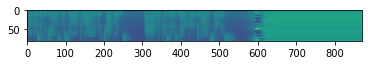

8 train.  1.011910042785517
8 val  0.9837047755718231


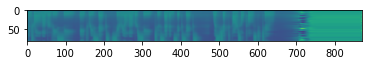

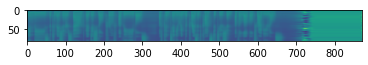

9 train.  1.0051765562810875
9 val  0.9750901609659195


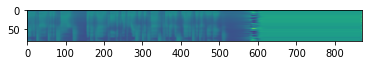

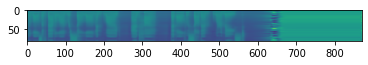

10 train.  0.9990323437711219
10 val  0.9733658730983734


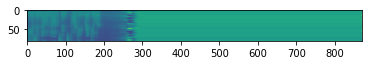

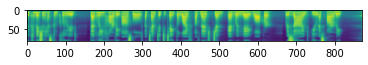

11 train.  0.993938594558643
11 val  0.9665749222040176


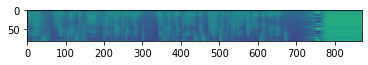

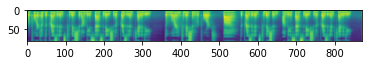

12 train.  0.9895174501903871
12 val  0.9643877446651459


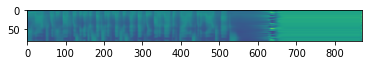

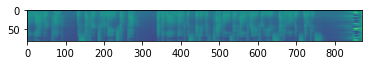

13 train.  0.9844477324610963
13 val  0.9608581513166428


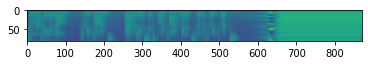

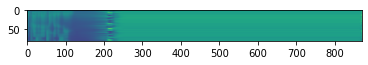

14 train.  0.980406140370699
14 val  0.9575725942850113


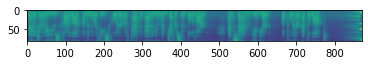

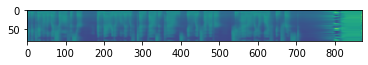

15 train.  0.976512861564791
15 val  0.9554395824670792


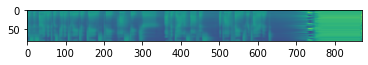

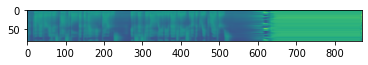

16 train.  0.9731724565239681
16 val  0.9515593498945236


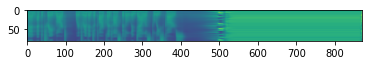

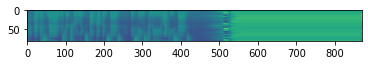

17 train.  0.9700531539882851
17 val  0.9532981961965561


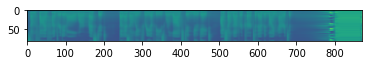

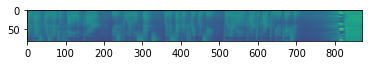

18 train.  0.9672369873040046
18 val  0.9552585035562515


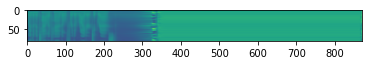

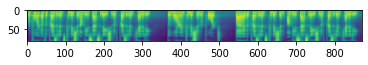

19 train.  0.9638300148285659
19 val  0.9467010200023651


In [25]:
for epoch in range(20):
  a =0
  model.train()
  indx = 0
  for i in DS_ljspeech_loader:
    indx += 1
    mask ,  phonemes_start, phonemes_duration, phonemes_code,  spectrogram =i
    mask ,  phonemes_start, phonemes_duration, phonemes_code,  spectrogram = mask.to(device) , phonemes_start.to(device), phonemes_duration.to(device), phonemes_code.to(device), spectrogram.to(device)
    preds1, preds2 = model( phonemes_code.long(), phonemes_duration.long()) 


    # print('predictions are made')
    # print(preds1.shape, preds2.shape, spectrogram.shape)
    if indx%200 ==0:
      plt.imshow(torch.squeeze(preds2[0]).cpu().detach().numpy()+torch.squeeze(preds1[0]).cpu().detach().numpy())
      plt.show()
    m1_loss = criterion(preds1*mask, spectrogram)
    m2_loss = criterion((preds1+preds2)*mask, spectrogram)

    loss = m1_loss + m2_loss
    a += loss.item()
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)
    optimizer.step()
  a  /= len(DS_ljspeech_loader)
  print(epoch, 'train. ', a)
  model.eval()
  b = 0
  for i in vDS_ljspeech_loader:
    mask ,  phonemes_start, phonemes_duration, phonemes_code,  spectrogram =i
    mask ,  phonemes_start, phonemes_duration, phonemes_code,  spectrogram = mask.to(device) , phonemes_start.to(device), phonemes_duration.to(device), phonemes_code.to(device), spectrogram.to(device)
    preds1, preds2 = model( phonemes_code.long(), phonemes_duration.long()) 
    m1_loss = criterion(preds1*mask, spectrogram)
    m2_loss = criterion((preds1+preds2)*mask, spectrogram)
    loss = m1_loss + m2_loss
    b += loss.item()
  b  /= len(vDS_ljspeech_loader)
  print(epoch, 'val ', b)

Datasets yield: text, phonemes_start, phonemes_duration, phonemes_code, spectrogram


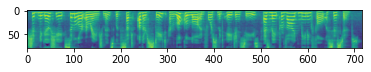

In [74]:
example_datapoint = train_dataset[777]
print(f"Datasets yield: {', '.join(example_datapoint.keys())}")
plt.imshow(example_datapoint['spectrogram']);

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
duration_model = DurationModel(256).to(device)
criterion= nn.MSELoss()
duration_optim = optim.Adam(duration_model.parameters(), lr=0.001)
# duration_scheduler = optim.lr_scheduler.StepLR(duration_optim, step_size=8, gamma=0.8)
# duration_scheduler = optim.lr_scheduler.ReduceLROnPlateau(duration_optim, 'min', verbose=True)

In [62]:
from torchvision import models, transforms, utils
from torch.utils.data import DataLoader

for epoch in range(10):
  a =0
  duration_model.train()
  for i in DS_ljspeech_loader:
    _,  _, phonemes_duration, phonemes_code,  _=i
    phonemes_duration, phonemes_code= phonemes_duration.to(device), phonemes_code.to(device)
    preds = duration_model(phonemes_code)
    loss = criterion(preds.double(), phonemes_duration.double()).to(device)
    a += loss.item()
    duration_optim.zero_grad()
    loss.backward()
    duration_optim.step()
  a  /= len(DS_ljspeech_loader)
  print(epoch, 'train. ', a)
  duration_model.eval()
  b = 0
  for i in vDS_ljspeech_loader:
    _,  _, phonemes_duration, phonemes_code,  _=i
    phonemes_duration, phonemes_code= phonemes_duration.to(device), phonemes_code.to(device)
    preds = duration_model(phonemes_code)
    loss = criterion(preds.double(), phonemes_duration.double()).to(device)
    b += loss.item()
  b  /= len(vDS_ljspeech_loader)
  print(epoch, 'val ', b)

0 train.  6.738168848488306
0 val  4.053719302564017
1 train.  4.530363408156854
1 val  3.6556366825707665
2 train.  4.208748922355764
2 val  3.4459177067211164
3 train.  3.990706380605992
3 val  3.436490990872225
4 train.  3.8208364390993723
4 val  3.2261839041251417
5 train.  3.6766832089989956
5 val  3.2328266416823817
6 train.  3.508470105698553
6 val  3.0832175005841878
7 train.  3.349509495822443
7 val  3.1546430237531133
8 train.  3.167127813716574
8 val  3.0730340209361318
9 train.  2.944358294484201
9 val  3.240394971815501


In [0]:
mdl = Encoder(256)

In [0]:
xx= mdl(phonemes_code.long())
xx.shape

torch.Size([13, 123, 512])

In [0]:
lj_speech.POSSIBLE_PHONEME_CODES

Here is an example datapoint:

Datasets yield: text, phonemes_start, phonemes_duration, phonemes_code, spectrogram


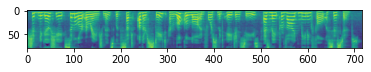

In [0]:
example_datapoint = train_dataset[777]
print(f"Datasets yield: {', '.join(example_datapoint.keys())}")
plt.imshow(example_datapoint['spectrogram']);

To "play" spectrograms, including those that you will generate, we will use another deep learning algorithm called [WaveGlow](https://arxiv.org/abs/1811.00002). It converts mel spectrograms to audio.

Fortunately, there *is* code for it on GitHub, so you won't have to reimplement it 🙂 Still, if you haven't done so, I encourage you to watch a short [video](https://www.youtube.com/watch?v=CqFIVCD1WWo) about a famous paper that it's based on.

In [0]:
vocoder = lj_speech.Vocoder()

In [83]:
print(example_datapoint['text'])

example_spectrogram = torch.from_numpy((spctrm+spctrm1)[:,:711]  )
audio = vocoder(example_spectrogram)
lj_speech.play_audio(audio)

should negotiate similar arrangements with such other state and local law enforcement agencies as may provide meaningful assistance.


## Method

Reimplement the baseline method defined by the diagram below. It's derived from a simplified version of the [DurIAN paper](https://arxiv.org/abs/1909.01700).

Just in case, here are some of the most notable differences from DurIAN:
* Prosodic boundary markers aren't used (we don't have them labeled), and thus there's no 'skip states' exclusion of prosodic boundaries' hidden states.
* Style codes aren't used too (same).
* Simpler network architectures.
* No pre-net in decoder.
* No attention used in decoder.
* Decoder's recurrent cell outputs single spectrogram frame at a time.

(diagram)

This picture is the simplified Figure 1 from the paper. **Use the paper as a reference**. If something is unclear from the diagram — and, in fact, much is intentionally omitted — search answers in the paper (but remain aware of the differences/simplifications in the above diagram) and other papers that the authors cite. There will even be details that aren't even mentioned anywhere in the paper, so you'll have to guess by your intuition. For instance, DurIAN paper doesn't explain batch size and sampling strategy, and even if it did, it would be irrelevant since we use different data.

Tips:
* Only compute loss on the 'original' parts of the spectrograms (don't include padding)!
* When using recurrent nets, [clip gradients' norm](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_).
* Since you will use recurrent nets, and the sequences in a batch will be of different lengths, you may find [sequence packing utility](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch) useful.

**Train this baseline so that the words are well-recognizable, and try to get rid of the "metallic", "tin sounding" voice.**

**Aim for something like this:**

In [0]:
lj_speech.play_audio(scipy.io.wavfile.read('ok.wav')[1])

**On the other hand, here is an example of insufficient quality:**

In [0]:
lj_speech.play_audio(scipy.io.wavfile.read('bad.wav')[1])

## Improving the Method

When you have the baseline working, seek the ways to improve quality and to decrease loss. Look into the paper and the relevant/neighbouring literature. Also, follow your intuition, e.g. for changing model complexity or regularization. For example, you can (but aren't obliged to) try borrowing more tricks from DurIAN; a couple of examples for inspiration:

* Make decoder recurrent cell autoregressive: use its output as its input at the next preiction step.
* Add pre-net to decoder.
* Add attention to decoder.
* Use more complex sub-network architectures (e.g. use CBHG).

In [0]:
name = 'durian'
torch.save(model.state_dict(), f'drive/My Drive/{name}.pth')



In [0]:
name = 'duration'
torch.save(duration_model.state_dict(), f'drive/My Drive/{name}.pth')

In [0]:
from pathlib import Path
class TextToSpeechSynthesizer:
    """
    When done, please fill this class. It should work out-of-the-box, i.e.
    have a simple interface, automatically load model weights,
    process text to speech at one command without errors etc.
    """
    def __init__(self, checkpoint_path  ):
        """
        Initialize anything you may need. For example, load model weights from disk.
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.durian = '/durian.pth'
        self.duration = '/duration.pth'
        self.sheckpoint =  checkpoint_path 
        self.durian_path = Path(self.sheckpoint+self.durian )
        self.modeldurian = durian().to(self.device )
        self.modeldurian.load_state_dict(torch.load(self.durian_path))

        self.duriationn_path = Path(self.sheckpoint+ self.duration)
        self.modeldurationn = DurationModel(256).to(self.device )
        self.modeldurationn.load_state_dict(torch.load(self.duriationn_path ))
    
    def synthesize_from_text(self, text):
        """
        Synthesize text into voice.

        text:
            str
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)

        """
        
        
        phonemes = lj_speech.text_to_phonemes(text)
        pc = torch.zeros(1,len(phonemes))
        for i in range(len(phonemes)):
            pc[0,i] = phonems_dict[phonemes[i]]
        preds_durations = self.modeldurationn(pc.to(self.device))
        limit = int(preds_durations.sum().item())
        preds1, preds2 = self.modeldurian(pc.long().to(self.device),preds_durations.long().to(self.device))
        spctrm = torch.squeeze(preds1).cpu() #.detach().numpy()
        spctrm1 = torch.squeeze(preds2).cpu() #.detach().numpy()
        spectrogram = (spctrm+spctrm1)[:,:limit] 
        # return self.synthesize_from_phonemes(phonemes)
        return vocoder(spectrogram)

    def synthesize_from_phonemes(self, phonemes, durations=None):
        """
        Synthesize phonemes into voice.

        phonemes:
            list of str
            ARPAbet phoneme codes.
        durations:
            list of int, optional
            Duration in spectrogram frames for each phoneme.
            If given, will be used for hard alignment in the model (like during
            training); otherwise, durations will be predicted by the duration
            model.
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        # Your code here

      #  phonemes = lj_speech.text_to_phonemes(text)
        pc = torch.zeros(1,len(phonemes))
        for i in range(len(phonemes)):
            pc[0,i] = phonems_dict[phonemes[i]]
        if durations is None:
            preds_durations = self.modeldurationn(pc.to(self.device))
            limit = int(preds_durations.sum().item())
            preds1, preds2 = self.modeldurian(pc.long().to(self.device), preds_durations.long().to(self.device))
        else:
            limit = int(durations.sum().item())
            preds1, preds2 = self.modeldurian(pc.long().to(self.device), durations.long().to(self.device)) 

        spctrm = torch.squeeze(preds1).cpu() #.detach().numpy()
        spctrm1 = torch.squeeze(preds2).cpu() #.detach().numpy()
        spectrogram = (spctrm+spctrm1)[:,:limit] 
        # return self.synthesize_from_phonemes(phonemes)
        return vocoder(spectrogram)

In [100]:
synthesizer = TextToSpeechSynthesizer("drive/My Drive", )
phonemes = "DH IH1 S pau pau pau IH1 Z pau pau pau S P AH1 R T AH1 AH1 AH1 pau".split()
lj_speech.play_audio(
    synthesizer.synthesize_from_phonemes(phonemes))

In [107]:
synthesizer = TextToSpeechSynthesizer("drive/My Drive", )
text = " I love my cat."
# text = "The five boxing wizards jump quickly."
# text = "The quick brown fox jumps over the lazy dog."
# text = "How about some school tech."
# text = "Last homework. We are in a deep trouble. No sleep tonight."

lj_speech.play_audio(
    synthesizer.synthesize_from_text(text))